# 🛰️ Classificador de Spoofing em sinais de GNSS

### **Projeto de Sinais e Sistemas (Parte 2)**

Esse notebook implementa classificadores para detectar sinais GNSS originados por spoofing. As features utilizadas são métricas extraídas de correlações e características retiradas dos sinais dos datasets FGI SpoofRepo e FGI OSNMA, que podem ser analisadas com mais detalhes no notebook da Parte 1 do projeto.

Os modelos implementados e comparados nesse projeto, são:
1. **Random Forest** - Classificador baseado em árvores de decisão
2. **SVM** - Support Vector Machine
3. **MLP** - Multi-Layer Perceptron

## Instalação de bibliotecas necessárias

In [215]:
# Instalação de dependências
%pip install pandas scikit-learn matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


## Importação de bibliotecas necessárias

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Carregamento e visão geral do dataset

In [217]:
DATA_PATH = '/home/rc-2d/gnss-spoofing-detection/data/gnss_dataset_labeled.csv'

df = pd.read_csv(DATA_PATH)

print(f"\nShape: {df.shape}")
print(f"\nColunas: {df.columns.tolist()}")
print(f"\nDistribuição das classes:")
print(df['label_name'].value_counts())
print(f"\nPrimeiras linhas do dataset:")
df.head()


Shape: (1016, 11)

Colunas: ['block_idx', 'time_s', 'best_prn', 'best_doppler', 'best_tau_chips', 'peak_snr', 'peak_raw', 'in_phase_lag', 'correlation_width', 'label', 'label_name']

Distribuição das classes:
label_name
spoofed      508
authentic    508
Name: count, dtype: int64

Primeiras linhas do dataset:


,block_idx,time_s,best_prn,best_doppler,best_tau_chips,peak_snr,peak_raw,in_phase_lag,correlation_width,label,label_name
0,245,0.245,14,9000,783.20,8.622576,805.099249,-323.72,4.48,1,spoofed
1,11,0.011,2,-6000,270.80,8.213540,781.976554,-457.64,4.44,1,spoofed
2,210,0.210,30,-10000,454.68,8.082415,823.438930,500.16,8.52,0,authentic
3,435,0.435,1,-9000,486.52,8.354364,778.355412,-410.96,6.52,1,spoofed
4,407,0.407,23,-3000,226.40,8.361149,772.747157,510.88,5.56,1,spoofed


## Preparação dos dados

In [256]:
# Features usadas na classificação
FEATURE_COLUMNS = ['best_prn', 'best_doppler', 'best_tau_chips', 'peak_snr', 'peak_raw', 'in_phase_lag', 'correlation_width']
# Label: 0 = authentic, 1 = spoofed
TARGET_COLUMN = 'label'

# Verificar valores ausentes (boa prática)
print("Valores ausentes por coluna:")
print(df[FEATURE_COLUMNS + [TARGET_COLUMN]].isnull().sum())

# Separar features e target
X = df[FEATURE_COLUMNS].values
y = df[TARGET_COLUMN].values

print(f"\nShape das features (X): {X.shape}")
print(f"Shape do target (y): {y.shape}")
print(f"\nDistribuição do target:")
print(f"- Autêntico (0): {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"- Spoofed (1): {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")

Valores ausentes por coluna:
best_prn             0
best_doppler         0
best_tau_chips       0
peak_snr             0
peak_raw             0
in_phase_lag         0
correlation_width    0
label                0
dtype: int64

Shape das features (X): (1016, 7)
Shape do target (y): (1016,)

Distribuição do target:
- Autêntico (0): 508 (50.0%)
- Spoofed (1): 508 (50.0%)


## Divisão em conjunto de treino e teste

In [219]:
# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

# Normalização das features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures normalizados com sucesso!")

Treino: 812 amostras
Teste: 204 amostras

Features normalizados com sucesso!


## Implementação dos classificadores

In [226]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    
    return metrics, y_pred, y_prob

# Dicionário para armazenar resultados
results = {}

print("Treinando Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
results['Random Forest'], rf_pred, rf_prob = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
print(f"Métricas: {results['Random Forest']}")

print("\nTreinando SVM...")
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)
svm_model.fit(X_train_scaled, y_train)
results['SVM'], svm_pred, svm_prob = evaluate_model(svm_model, X_test_scaled, y_test, 'SVM')
print(f"Métricas: {results['SVM']}")


Treinando Random Forest...
Métricas: {'model': 'Random Forest', 'accuracy': 0.8627450980392157, 'precision': 0.8363636363636363, 'recall': 0.9019607843137255, 'f1': 0.8679245283018868, 'roc_auc': 0.9423298731257209}

Treinando SVM...
Métricas: {'model': 'SVM', 'accuracy': 0.8872549019607843, 'precision': 0.8434782608695652, 'recall': 0.9509803921568627, 'f1': 0.8940092165898618, 'roc_auc': 0.9639561707035755}


Treinando MLP...
Métricas: {'model': 'MLP', 'accuracy': 0.8921568627450981, 'precision': 0.8636363636363636, 'recall': 0.9313725490196079, 'f1': 0.8962264150943396, 'roc_auc': 0.9683775470972703}
Epochs treinadas: 27
Loss final: 0.1699


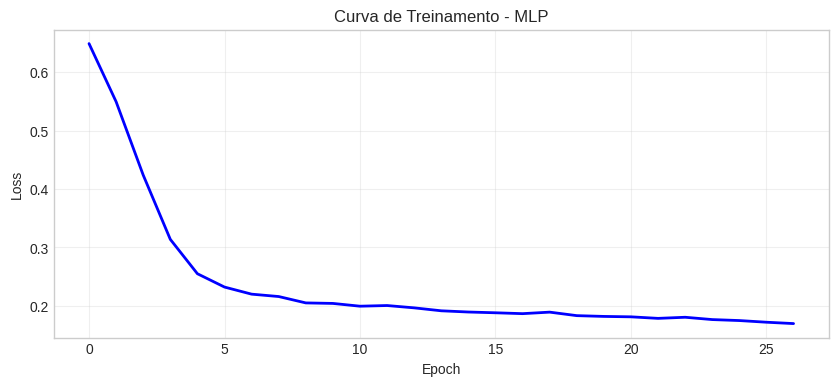

In [234]:
print("Treinando MLP...")

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001, 
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=False
)

mlp_model.fit(X_train_scaled, y_train)
results['MLP'], mlp_pred, mlp_prob = evaluate_model(mlp_model, X_test_scaled, y_test, 'MLP')

print(f"Métricas: {results['MLP']}")
print(f"Epochs treinadas: {mlp_model.n_iter_}")
print(f"Loss final: {mlp_model.loss_:.4f}")

# Plotar curva de perda do MLP
plt.figure(figsize=(10, 4))
plt.plot(mlp_model.loss_curve_, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curva de Treinamento - MLP')
plt.grid(True, alpha=0.3)
plt.show()

## Análise dos resultados e comparação entre os modelos

In [255]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.reset_index(drop=True)
metrics_df = metrics_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

print(metrics_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else x))
print("\n")

# Encontrar melhor modelo por métrica
print("Melhores modelos por métrica:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    best_idx = metrics_df[metric].astype(float).idxmax()
    best_model = metrics_df.loc[best_idx, 'model']
    best_value = metrics_df.loc[best_idx, metric]
    print(f"- {metric:12s}: {best_model} ({best_value:.4f})")

        model accuracy precision recall     f1 roc_auc
Random Forest   0.8627    0.8364 0.9020 0.8679  0.9423
          SVM   0.8873    0.8435 0.9510 0.8940  0.9640
          MLP   0.8922    0.8636 0.9314 0.8962  0.9684


Melhores modelos por métrica:
- accuracy    : MLP (0.8922)
- precision   : MLP (0.8636)
- recall      : SVM (0.9510)
- f1          : MLP (0.8962)
- roc_auc     : MLP (0.9684)


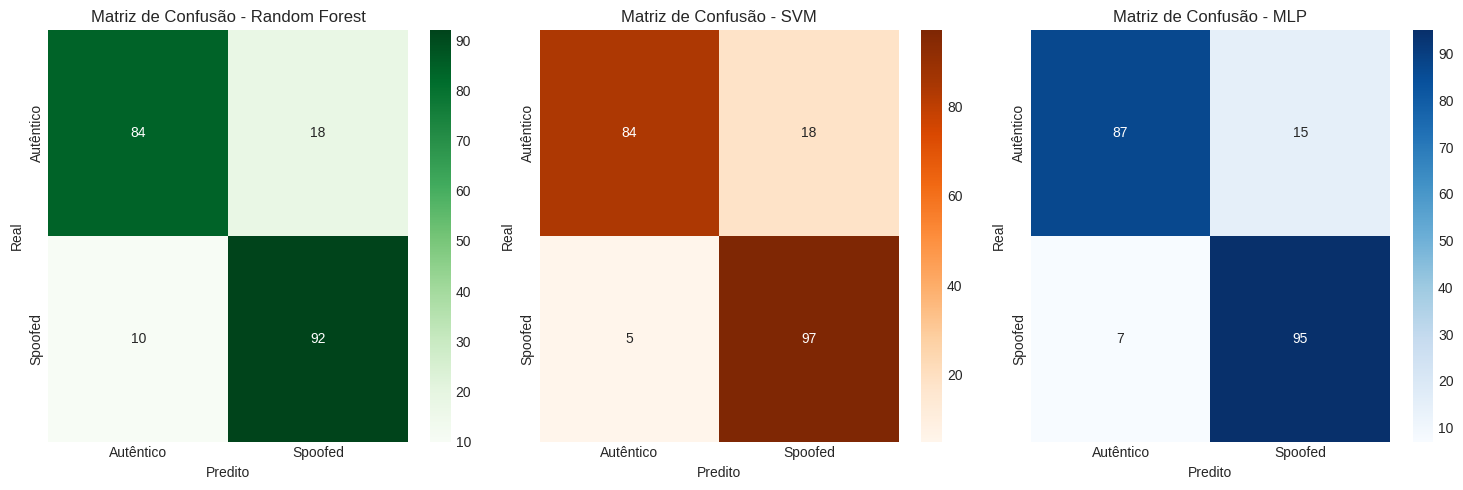


RELATÓRIO DE CLASSIFICAÇÃO - MLP (Melhor F1-Score)

              precision    recall  f1-score   support

   Autêntico       0.93      0.85      0.89       102
     Spoofed       0.86      0.93      0.90       102

    accuracy                           0.89       204
   macro avg       0.89      0.89      0.89       204
weighted avg       0.89      0.89      0.89       204



In [258]:
# Obter predições de todos os modelos
all_predictions = {
    'Random Forest': rf_pred,
    'SVM': svm_pred,
    'MLP': mlp_pred
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

colors = ['Greens', 'Oranges', 'Blues']

# Plotar matrizes de confusão
for idx, (model_name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=colors[idx], ax=axes[idx],
                xticklabels=['Autêntico', 'Spoofed'],
                yticklabels=['Autêntico', 'Spoofed'])
    axes[idx].set_xlabel('Predito')
    axes[idx].set_ylabel('Real')
    axes[idx].set_title(f'Matriz de Confusão - {model_name}')

plt.tight_layout()
plt.show()

# Imprimir relatório de classificação detalhado para o melhor modelo
best_model_name = metrics_df.loc[metrics_df['f1'].astype(float).idxmax(), 'model']
best_pred = all_predictions[best_model_name]

print(f"\nRELATÓRIO DE CLASSIFICAÇÃO - {best_model_name} (Melhor F1-Score)\n")
print(classification_report(y_test, best_pred, target_names=['Autêntico', 'Spoofed']))

## Importância das features no modelo Random Forest

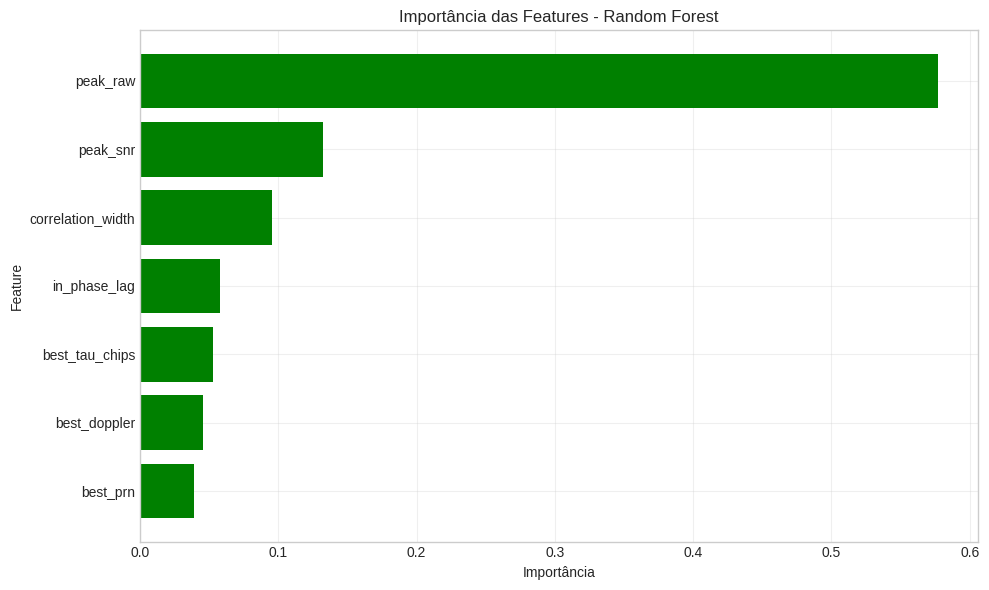


Ranking de Importância das Features:
- peak_raw            : 0.5772
- peak_snr            : 0.1319
- correlation_width   : 0.0956
- in_phase_lag        : 0.0578
- best_tau_chips      : 0.0527
- best_doppler        : 0.0455
- best_prn            : 0.0392


In [254]:
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='green')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.title('Importância das Features - Random Forest')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRanking de Importância das Features:")
for idx, row in feature_importance.iloc[::-1].iterrows():
    print(f"- {row['feature']:20s}: {row['importance']:.4f}")